<a id='FigurePretrainedModelTop'></a>
# Figures Illustrating Pretrained Model Predictions on the Experimental Dataset

Illustrations of the performance of the pretrained ensemble of LSTM networks, predicting the final (equilibrium) magnitude of the porous silicon (PSi) sensor response. At every time point the models prediction is based on data from the current and past timesteps.

1. 
2. 


## Plot of experimental, pretrained model ensemble prediction (mean & variance) and ideal responses

1/1 [==============================] - 1s 699ms/step


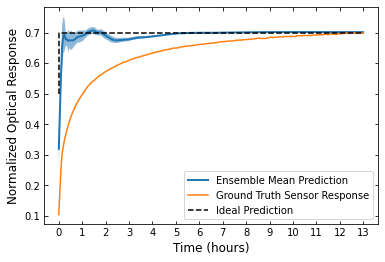

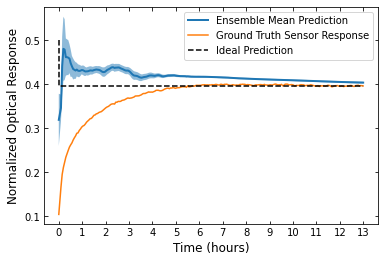

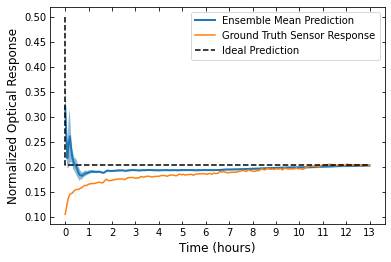

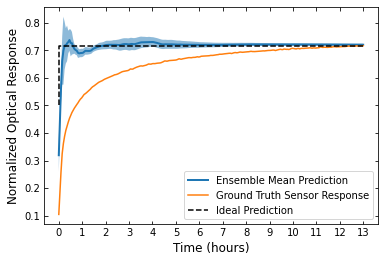

In [16]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split

# 
NumEnsemble = 10
SequenceLength = 250
experiment_num = [11,46,57,70]#16,42
StdevsFromMean = 2 #1, 2 and 3 standard deviations away from the mean encompasses 68%, 95% and 99.7% of the distribution, respectively 
test_split = 0.2

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None)
time = df_full.iloc[0,1:]/3600
labels = df_full.iloc[1:,0]
df_data = df_full.iloc[1:,1:]

df = pd.read_csv(r"../TrainingData/SimulatedTrainingSet10000.csv",sep=',',header=0)
df_simulated = df.iloc[:,1:]

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str)

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_simulated.min().min(), df_simulated.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)

# slicing 
X_test = df_norm_test.iloc[:,:SequenceLength].values
y_test = df_norm_test.iloc[:,SequenceLength-1].values
X_test = np.expand_dims(X_test, 2)
y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
y_test = np.expand_dims(y_test, 2)


Mean = tf.zeros([1,SequenceLength])
Variance = tf.zeros([1,SequenceLength])
X_predict = np.expand_dims(X_test[experiment_num,::], 2)

# idealTime = np.append([0,0], time.iloc[2:,].values)
# idealPrediction = np.ones(len(idealTime))*X_predict[0,-1,0]
# idealPrediction[0] = 0.5

NumGoodModels = 0

for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    loss = bestModel.evaluate(X_test, y_test)
    if(loss<500):#-2
        prediction = bestModel.predict(X_predict)
        Mean += prediction[:,:,0]
        Variance += (prediction[:,:,0])**2 + prediction[:,:,1]**2
        NumGoodModels += 1
Mean /= NumGoodModels
Variance /= NumGoodModels
Variance -= Mean**2
Mean = np.squeeze(Mean)
Stdev = np.squeeze(Variance**0.5)
idealTime = np.append([0,0], time.iloc[2:,].values)
time = np.array(time, dtype=float)

for mean,x,stdev,num in zip(Mean,X_predict,Stdev,experiment_num):
    
    idealPrediction = np.ones(len(idealTime))*x[-1,0,0]
    idealPrediction[0] = 0.5

    fig, ax = plt.subplots()

    ax.fill_between(time, (mean+stdev*StdevsFromMean), (mean-stdev*StdevsFromMean), alpha=.5, linewidth=0)
    ax.plot(time, mean, linewidth=2, label='Ensemble Mean Prediction')
    plt.plot(time,tf.squeeze(x), label="Ground Truth Sensor Response")
    plt.plot(idealTime,idealPrediction, label="Ideal Prediction",color='k',linestyle='--')
    
    ax.set_ylabel('Normalized Optical Response', fontsize = 12)
    ax.set_xlabel('Time (hours)', fontsize = 12)
    
    ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
    ax.tick_params(direction="in")
    ax.set_xticks(range(14))
    ax.legend()#loc='upper right')
    plt.savefig(f"../Figures/PretrainedEnsemblePredictionIdealResponses{num}.tif", dpi=200, bbox_inches='tight')
    plt.show()

## Histogram of experimental and pretrained model predicted t90 times

3/3 [==============================] - 1s 35ms/step

prediction t90 summary statistics
               0
count  78.000000
mean    2.676143
std     3.497139
min     0.103980
25%     0.181964
50%     1.195766
75%     3.223369
max    12.997456

experimental t90 summary statistics
               0
count  78.000000
mean    3.870576
std     2.569388
min     0.363929
25%     2.352539
50%     3.535308
75%     4.497120
max    12.945466

ratio of experimental to predicted t90 summary statistics
               0
count  78.000000
mean   10.769240
std    14.926135
min     0.123810
25%     0.913427
50%     2.288462
75%    21.025000
max    48.500000


/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


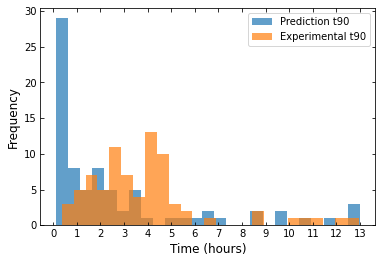

In [8]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split

## input parameters

# number of models in the ensemble
NumEnsemble = 10

# length of time series
SequenceLength = 250
TestOrTrainDataset = 'test' #'train' or 'test'
test_split = 0.2

# t90 is defined as the time until the response settles to within this fraction of the equilibrium response indefinitely
t90Window = 0.1

NumberOfBins = 25

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None)
time = df_full.iloc[0,1:]/3600
idealTime = np.append([0,0], time.iloc[2:,].values)
labels = df_full.iloc[1:,0]
df_data = df_full.iloc[1:,1:]

df = pd.read_csv(r"../TrainingData/SimulatedTrainingSet10000.csv",sep=',',header=0)
df_simulated = df.iloc[:,1:]

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str)

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_simulated.min().min(), df_simulated.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)

if TestOrTrainDataset == 'train':
    X_train = df_norm_train.iloc[:,:SequenceLength].values
    y_train = df_norm_train.iloc[:,SequenceLength-1].values
    X_train = np.expand_dims(X_train, 2)
    y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
    y_train = np.expand_dims(y_train, 2)
    X = X_train
    y = y_train
elif TestOrTrainDataset == 'test':
    X_test = df_norm_test.iloc[:,:SequenceLength].values
    y_test = df_norm_test.iloc[:,SequenceLength-1].values
    X_test = np.expand_dims(X_test, 2)
    y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
    y_test = np.expand_dims(y_test, 2)
    X = X_test
    y = y_test
    
Mean = tf.zeros([len(X),SequenceLength])
Variance = tf.zeros([len(X),SequenceLength])
Prediction = tf.zeros([len(X),SequenceLength])

for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    loss = bestModel.evaluate(X, y)
    
    # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
    # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
    # for some reason predicting on X_train[0:6,::] for example does give identical results to predicting any one indivdually..
    Prediction = bestModel.predict(X)
    
    ## make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
    # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X[i,::], 0)) for  i in range(len(X))])
    
    Mean += Prediction[:,:,0]
    Variance += (Prediction[:,:,0])**2 + Prediction[:,:,1]**2
    
Mean /= NumEnsemble
Variance /= NumEnsemble
Variance -= Mean**2

PredictionT90 = []
ExperimentalT90 = []
MeanNormVariance = []

for mean,x,variance in zip(Mean,X,Variance):
    
    # Boolean 1D array of when the model prediction or experimental response was within 10% of
    # the final equilibrium experimental response
    PredictionEquilibriumSeries = np.array((mean > x[-1]*(1-t90Window))&(mean < x[-1]*(1+t90Window)))
    ExperimentalEquilibriumSeries = np.array((x > x[-1]*(1-t90Window))&(x < x[-1]*(1+t90Window)))
    NormVariance = variance
    
    # finds the latest time point at which the model was outisde the range of final equilirium response +/- 10%
    PredictionT90.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeries)))
    ExperimentalT90.append(SequenceLength - np.argmin(np.flip(ExperimentalEquilibriumSeries)))
    MeanNormVariance.append(np.mean(NormVariance))
    
PredictionT90 = [t90 * time.iloc[-1]/250 for t90 in PredictionT90]
ExperimentalT90 = [t90 * time.iloc[-1]/250 for t90 in ExperimentalT90]
MeanNormVariance = np.array(MeanNormVariance)

print('\nprediction t90 summary statistics')
print(pd.DataFrame(PredictionT90).describe())
print('\nexperimental t90 summary statistics')
print(pd.DataFrame(ExperimentalT90).describe())
print('\nratio of experimental to predicted t90 summary statistics')
print(pd.DataFrame(np.array(ExperimentalT90)/np.array(PredictionT90)).describe())

freq, bins = np.histogram(PredictionT90, NumberOfBins)

BinNormVarianceMean = []
BinNormVarianceStdev = []
for i in range(NumberOfBins):
    indices = np.where((PredictionT90 >= bins[i]) & (PredictionT90 < bins[i+1]))
    BinNormVarianceMean.append(np.mean(MeanNormVariance[indices]))
    BinNormVarianceStdev.append(np.std(MeanNormVariance[indices]))

fig, ax = plt.subplots()
ax.hist(PredictionT90, histtype="stepfilled", bins=NumberOfBins, alpha=0.7,label='Prediction t90')
ax.hist(ExperimentalT90, histtype="stepfilled", bins=NumberOfBins, alpha=0.7,label='Experimental t90')

ax.set_ylabel('Frequency', fontsize = 12)
ax.set_xlabel('Time (hours)', fontsize = 12)

ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
ax.tick_params(direction="in")
ax.set_xticks(range(14))
ax.legend(loc='upper right')

plt.savefig(".."+"/Figures/PredictedPretrainedt90Histogram.tif", dpi=200, bbox_inches='tight')
plt.show()

## Histogram of experimental and pretrained model predicted t90 times with variance subplot indicating S/N

2023-10-25 21:03:34.839771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-25 21:03:34.843731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-25 21:03:34.843908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-25 21:03:34.844295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

2023-10-25 21:03:40.297334: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


3/3 [==============================] - 2s 30ms/step - loss: 58.3955


2023-10-25 21:03:40.855178: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3/3 [==============================] - 1s 35ms/step

prediction t90 summary statistics
               0
count  78.000000
mean    2.676143
std     3.497139
min     0.103980
25%     0.181964
50%     1.195766
75%     3.223369
max    12.997456

experimental t90 summary statistics
               0
count  78.000000
mean    3.870576
std     2.569388
min     0.363929
25%     2.352539
50%     3.535308
75%     4.497120
max    12.945466

ratio of experimental to predicted t90 summary statistics
               0
count  78.000000
mean   10.769240
std    14.926135
min     0.123810
25%     0.913427
50%     2.288462
75%    21.025000
max    48.500000


/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


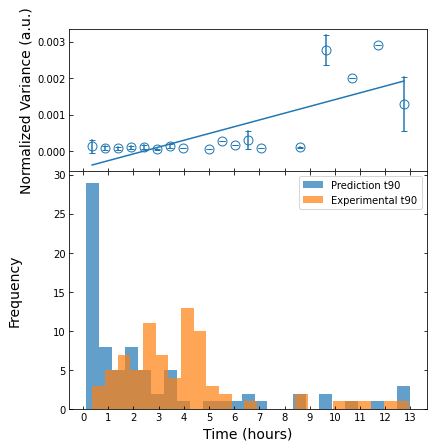

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split
import pylab
from sklearn.linear_model import LinearRegression

## input parameters

# number of models in the ensemble
NumEnsemble = 10
# length of time series
SequenceLength = 250
TestOrTrainDataset = 'test' #'train' or 'test'
t90Window = 0.1 # t90 is defined as the time until the response settles to within this fraction of the equilibrium response indefinitely
test_split = 0.2
NumberOfBins = 25
viridisColour1 = 30
viridisColour2 = 120
markerSize = 80

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None)
time = df_full.iloc[0,1:]/3600
idealTime = np.append([0,0], time.iloc[2:,].values)
labels = df_full.iloc[1:,0]
df_data = df_full.iloc[1:,1:]

df = pd.read_csv(r"../TrainingData/SimulatedTrainingSet10000.csv",sep=',',header=0)
df_simulated = df.iloc[:,1:]

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str)

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_simulated.min().min(), df_simulated.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)

if TestOrTrainDataset == 'train':
    X_train = df_norm_train.iloc[:,:SequenceLength].values
    y_train = df_norm_train.iloc[:,SequenceLength-1].values
    X_train = np.expand_dims(X_train, 2)
    y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
    y_train = np.expand_dims(y_train, 2)
    X = X_train
    y = y_train
elif TestOrTrainDataset == 'test':
    X_test = df_norm_test.iloc[:,:SequenceLength].values
    y_test = df_norm_test.iloc[:,SequenceLength-1].values
    X_test = np.expand_dims(X_test, 2)
    y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
    y_test = np.expand_dims(y_test, 2)
    X = X_test
    y = y_test
    
Mean = tf.zeros([len(X),SequenceLength])
Variance = tf.zeros([len(X),SequenceLength])
Prediction = tf.zeros([len(X),SequenceLength])

for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    loss = bestModel.evaluate(X, y)    
    # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
    # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
    # for some reason predicting on X_train[0:6,::] for example does give identical results to predicting any one indivdually..
    Prediction = bestModel.predict(X)
    

    # make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
    # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X[i,::], 0)) for  i in range(len(X))])
    
    Mean += Prediction[:,:,0]
    Variance += (Prediction[:,:,0])**2 + Prediction[:,:,1]**2
    
Mean /= NumEnsemble
Variance /= NumEnsemble
Variance -= Mean**2

PredictionT90 = []
ExperimentalT90 = []
MeanNormVariance = []

for mean,x,variance in zip(Mean,X,Variance):
    
    # Boolean 1D array of when the model prediction or experimental response was within 10% of
    # the final equilibrium experimental response
    PredictionEquilibriumSeries = np.array((mean > x[-1]*(1-t90Window))&(mean < x[-1]*(1+t90Window)))
    ExperimentalEquilibriumSeries = np.array((x > x[-1]*(1-t90Window))&(x < x[-1]*(1+t90Window)))
    NormVariance = variance/x[-1]
    
    # finds the latest time point at which the model was outisde the range of final equilirium response +/- 10%
    PredictionT90.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeries)))
    ExperimentalT90.append(SequenceLength - np.argmin(np.flip(ExperimentalEquilibriumSeries)))
    MeanNormVariance.append(np.mean(NormVariance))
    
PredictionT90 = [t90 * time.iloc[-1]/250 for t90 in PredictionT90]
ExperimentalT90 = [t90 * time.iloc[-1]/250 for t90 in ExperimentalT90]
MeanNormVariance = np.array(MeanNormVariance)

print('\nprediction t90 summary statistics')
print(pd.DataFrame(PredictionT90).describe())
print('\nexperimental t90 summary statistics')
print(pd.DataFrame(ExperimentalT90).describe())
print('\nratio of experimental to predicted t90 summary statistics')
print(pd.DataFrame(np.array(ExperimentalT90)/np.array(PredictionT90)).describe())

freq, bins = np.histogram(PredictionT90, NumberOfBins)
BinNormVarianceMean = []
BinNormVarianceStdev = []
for i in range(NumberOfBins):
    indices = np.where((PredictionT90 >= bins[i]) & (PredictionT90 <= bins[i+1]))
    BinNormVarianceMean.append(np.mean(MeanNormVariance[indices]))
    BinNormVarianceStdev.append(np.std(MeanNormVariance[indices]))

BinCenters = np.array([(bins[i+1]+bins[i])/2 for i in range(NumberOfBins)])
BinNormVarianceMean = np.array(BinNormVarianceMean)
BinNormVarianceStdev = np.array(BinNormVarianceStdev)

LinearFit = LinearRegression()
BinCentersDropNa = BinCenters[~np.isnan(BinNormVarianceMean)]
BinNormVarianceMeanDropNa = BinNormVarianceMean[~np.isnan(BinNormVarianceMean)]
BinNormVarianceStdevDropNa = BinNormVarianceStdev[~np.isnan(BinNormVarianceMean)]
LinearFit.fit(np.reshape(BinCentersDropNa,(-1, 1)), np.reshape(BinNormVarianceMeanDropNa,(-1, 1)))

fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [1.8, 3]},figsize=[6.4, 7])

ax1.scatter(BinCentersDropNa,BinNormVarianceMeanDropNa, facecolor=(0,0,0,0), marker='o', s=markerSize, edgecolor='tab:blue')#pylab.cm.viridis(viridisColour1))
ax1.plot([BinCentersDropNa, BinCentersDropNa], [BinNormVarianceMeanDropNa+BinNormVarianceStdevDropNa, BinNormVarianceMeanDropNa-BinNormVarianceStdevDropNa], marker="_", color='tab:blue')#pylab.cm.viridis(viridisColour1))
ax1.plot(BinCentersDropNa,LinearFit.predict(np.reshape(BinCentersDropNa,(-1, 1))),color='tab:blue')#pylab.cm.viridis(viridisColour1))
ax1.set_ylabel('Normalized Variance (a.u.)', fontsize = 14)
ax1.tick_params(direction="in")

ax2.hist(PredictionT90, histtype="stepfilled", bins=NumberOfBins, alpha=0.7,label='Prediction t90',color='tab:blue')#pylab.cm.viridis(viridisColour1))
ax2.hist(ExperimentalT90, histtype="stepfilled", bins=NumberOfBins, alpha=0.7,label='Experimental t90',color='tab:orange')#pylab.cm.viridis(viridisColour2))

ax2.set_ylabel('Frequency', fontsize = 14, labelpad=32)
ax2.set_xlabel('Time (hours)', fontsize = 14)

ax2.tick_params(right=True, top=True, labelright=False, labeltop=False)
ax2.tick_params(direction="in")
ax2.set_xticks(range(14))
ax2.legend(loc='upper right')

fig.subplots_adjust(hspace=0)

plt.savefig(".."+"/Figures/PredictedPretrainedt90HistogramNormVariance.tif", dpi=200, bbox_inches='tight')
plt.show()

## Box and whisker plot of ratio of experimental to pretrained model predicted t90 times

3/3 [==============================] - 1s 26ms/step
               0
count  78.000000
mean   10.769240
std    14.926135
min     0.123810
25%     0.913427
50%     2.288462
75%    21.025000
max    48.500000


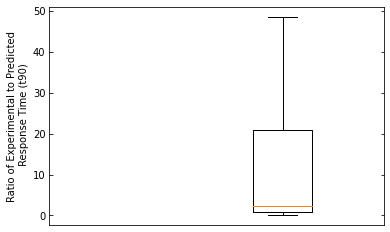

In [10]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split

## input parameters

# number of models in the ensemble
NumEnsemble = 10
# length of time series
SequenceLength = 250
TestOrTrainDataset = 'test' #'train' or 'test'
t90Window = 0.1 # t90 is defined as the time until the response settles to within this fraction of the equilibrium response indefinitely
test_split = 0.2

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None)
time = df_full.iloc[0,1:]/3600
idealTime = np.append([0,0], time.iloc[2:,].values)
labels = df_full.iloc[1:,0]
df_data = df_full.iloc[1:,1:]

df = pd.read_csv(r"../TrainingData/SimulatedTrainingSet10000.csv",sep=',',header=0)
df_simulated = df.iloc[:,1:]

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str)

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_simulated.min().min(), df_simulated.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)

if TestOrTrainDataset == 'train':
    X_train = df_norm_train.iloc[:,:SequenceLength].values
    y_train = df_norm_train.iloc[:,SequenceLength-1].values
    X_train = np.expand_dims(X_train, 2)
    y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
    y_train = np.expand_dims(y_train, 2)
    X = X_train
    y = y_train
elif TestOrTrainDataset == 'test':
    X_test = df_norm_test.iloc[:,:SequenceLength].values
    y_test = df_norm_test.iloc[:,SequenceLength-1].values
    X_test = np.expand_dims(X_test, 2)
    y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
    y_test = np.expand_dims(y_test, 2)
    X = X_test
    y = y_test
    
Mean = tf.zeros([len(X),SequenceLength])
Prediction = tf.zeros([len(X),SequenceLength])

for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    loss = bestModel.evaluate(X, y)    
    # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
    # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
    # for some reason predicting on X_train[0:6,::] for example does give identical results to predicting any one indivdually..
    Prediction = bestModel.predict(X)
    

    # make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
    # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X[i,::], 0)) for  i in range(len(X))])
    
    Mean += Prediction[:,:,0]
        
Mean /= NumEnsemble

PredictionT90 = []
ExperimentalT90 = []

for mean,x in zip(Mean,X):
    
    # Boolean 1D array of when the model prediction or experimental response was within 10% of
    # the final equilibrium experimental response
    PredictionEquilibriumSeries = np.array((mean > x[-1]*(1-t90Window))&(mean < x[-1]*(1+t90Window)))
    ExperimentalEquilibriumSeries = np.array((x > x[-1]*(1-t90Window))&(x < x[-1]*(1+t90Window)))

    # finds the latest time point at which the model was outisde the range of final equilirium response +/- 10%
    PredictionT90.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeries)))
    ExperimentalT90.append(SequenceLength - np.argmin(np.flip(ExperimentalEquilibriumSeries)))
    
PredictionT90 = [t90 * time.iloc[-1]/250 for t90 in PredictionT90]
ExperimentalT90 = [t90 * time.iloc[-1]/250 for t90 in ExperimentalT90]

RatioT90 = np.array(ExperimentalT90)/np.array(PredictionT90)

print(pd.DataFrame(RatioT90).describe())

fig, ax = plt.subplots()
ax.boxplot(RatioT90)#,showmeans=False,showextrema=False,showmedians=True,quantiles=[0.25,0.75])

# plt.xlabel("")
plt.ylabel("Ratio of Experimental to Predicted\n Response Time (t90)")
# plt.text(0.55,25,"Mean "+str(RatioT90.mean())+"\nLower Quartile "+str(np.quantile(RatioT90,0.25))+"\nMedian "+str(np.quantile(RatioT90,0.5))+"\nUpper Quartile "+str(np.quantile(RatioT90,0.75)))
ax.tick_params(right=True, top=False, bottom=False, labelbottom=False, labelright=False, labeltop=False)
ax.tick_params(direction="in")
ax.set_xlim([0.4,1.26])

plt.savefig("../Figures/BoxandWhiskerPlotPretrainedPredictedt90Ratio.tif", dpi=200, bbox_inches='tight')
plt.show()

# Useful plots, but not figures

## Individual plots of all experimental, ensemble prediction (mean & variance) and ideal responses

3/3 [==============================] - 1s 35ms/step


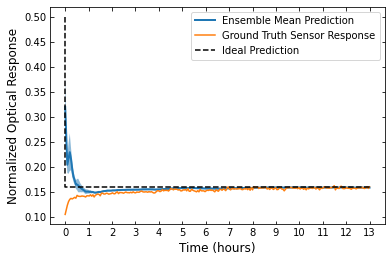

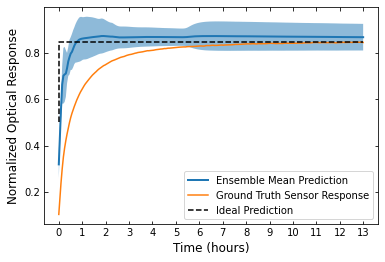

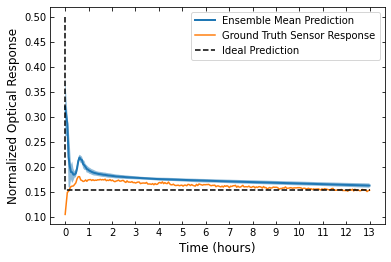

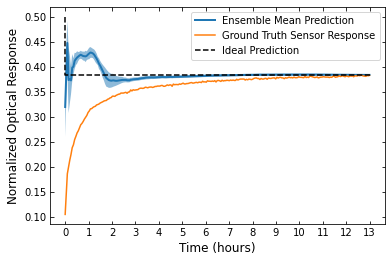

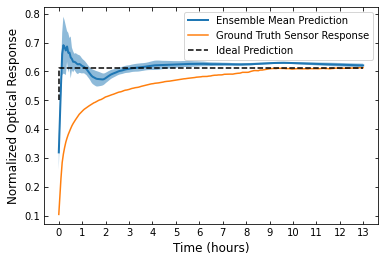

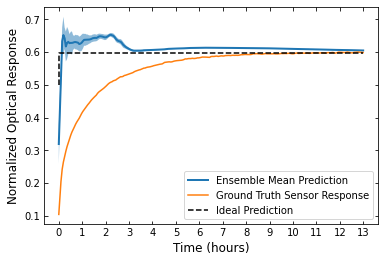

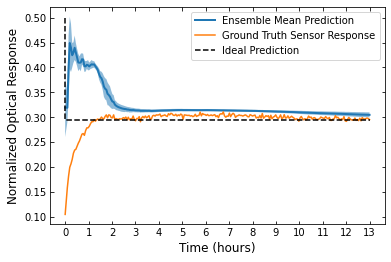

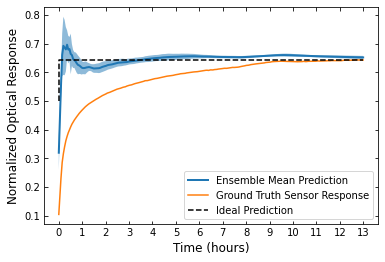

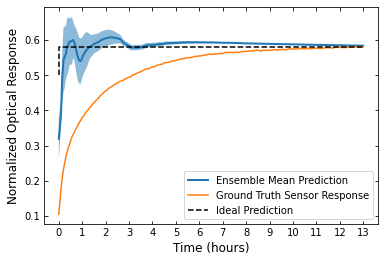

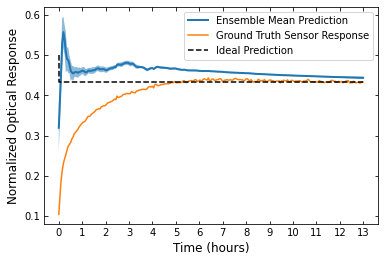

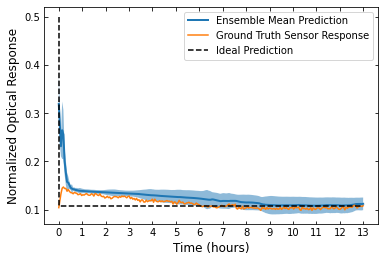

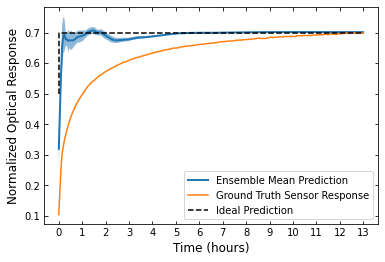

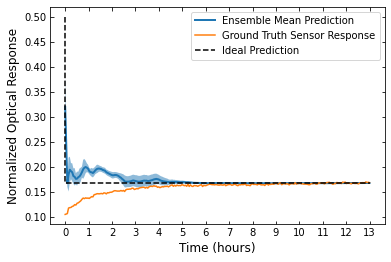

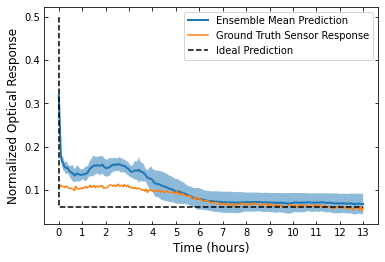

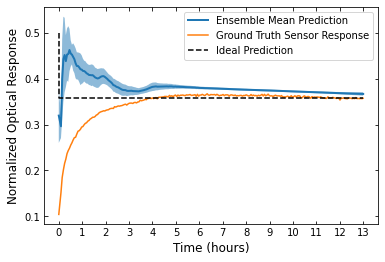

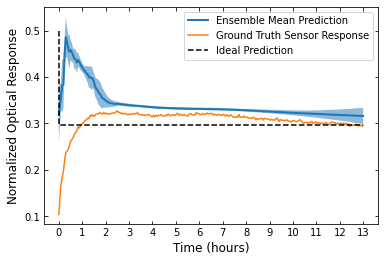

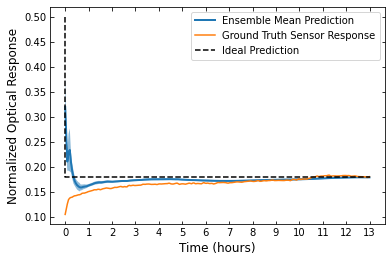

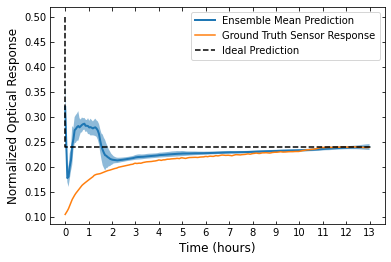

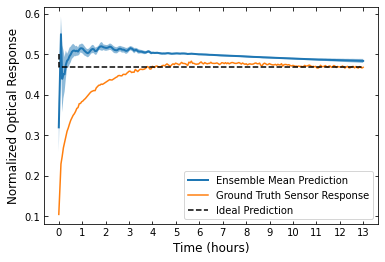

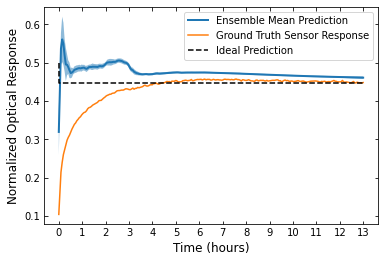

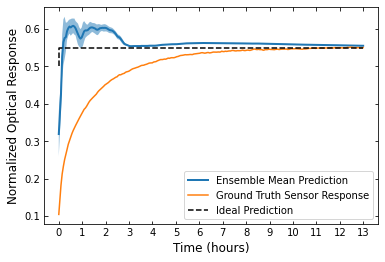

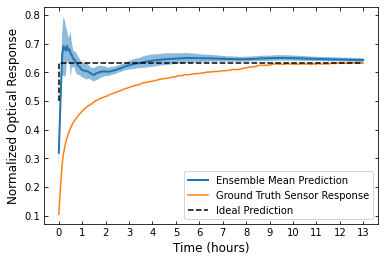

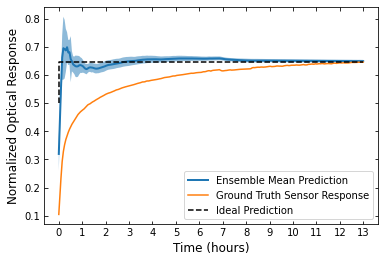

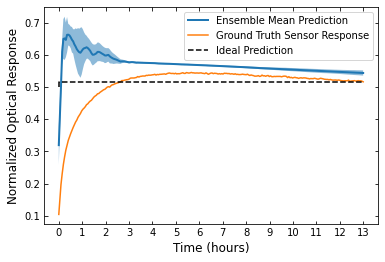

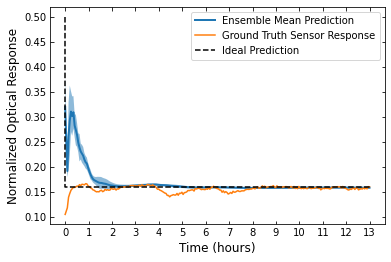

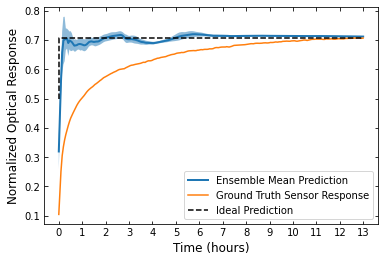

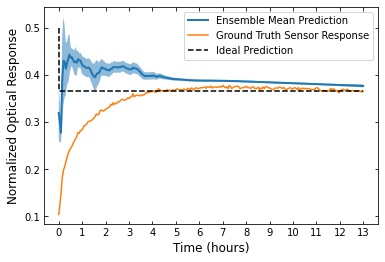

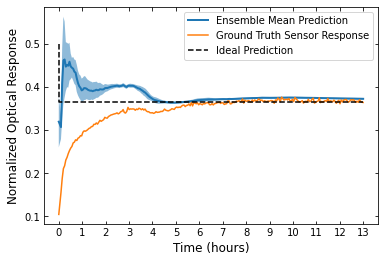

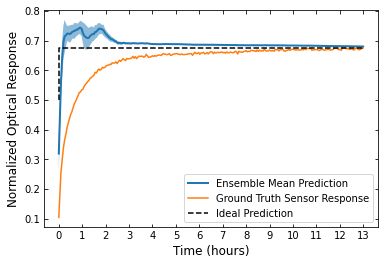

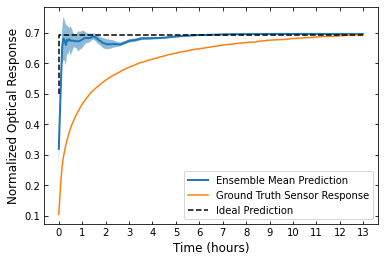

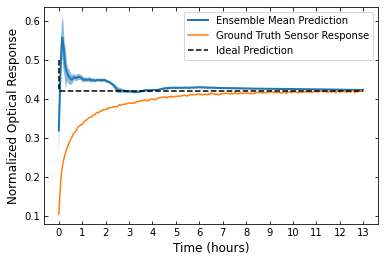

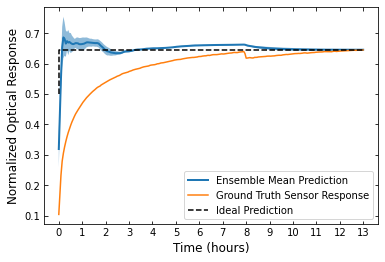

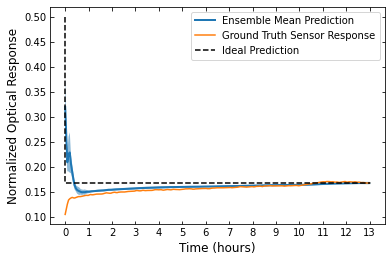

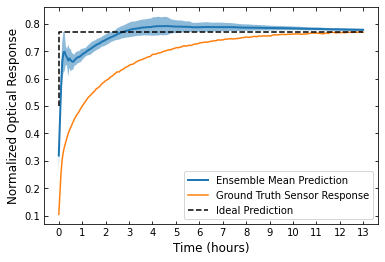

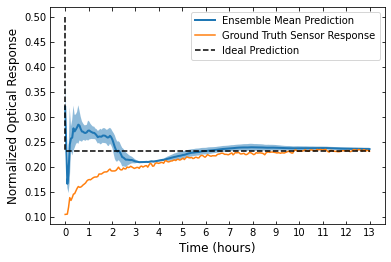

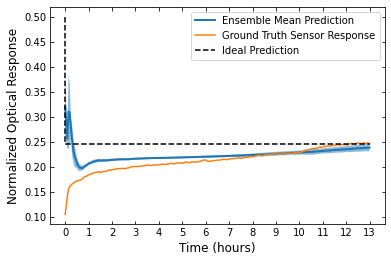

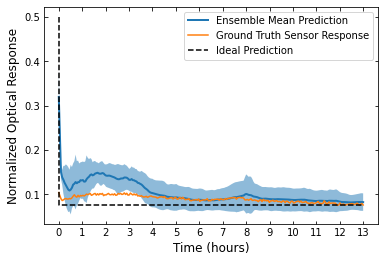

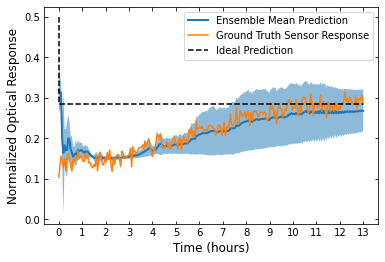

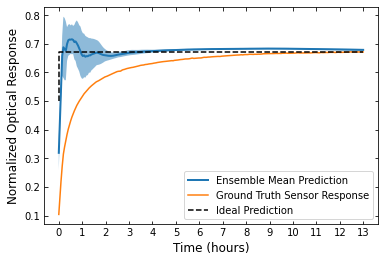

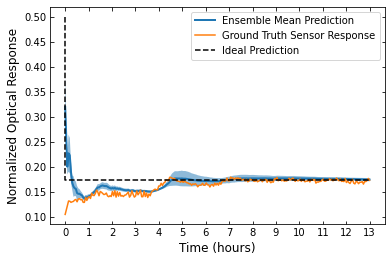

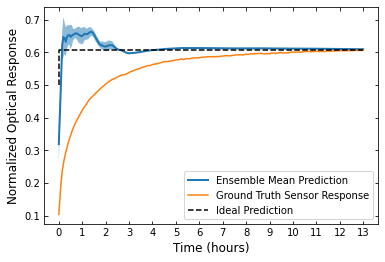

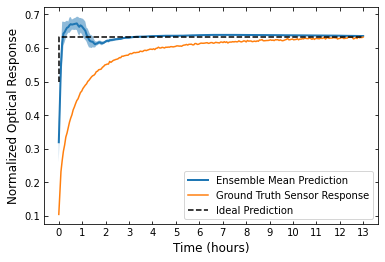

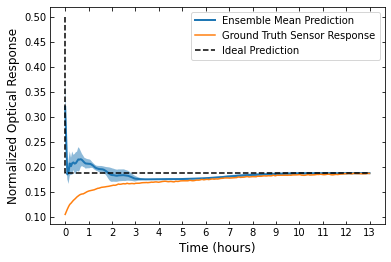

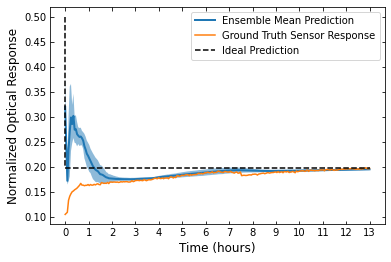

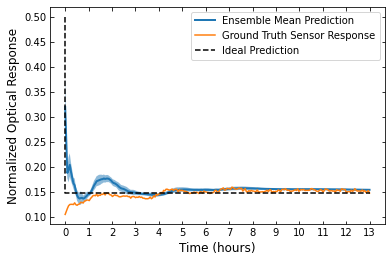

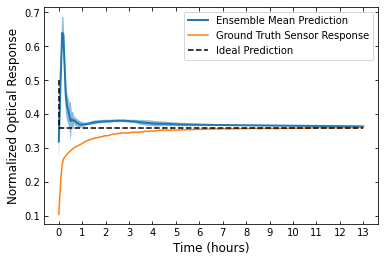

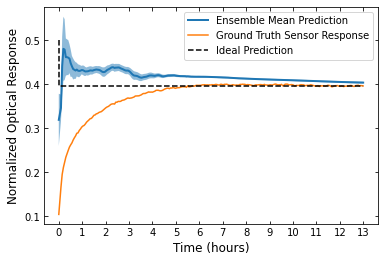

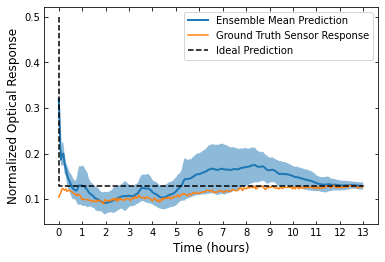

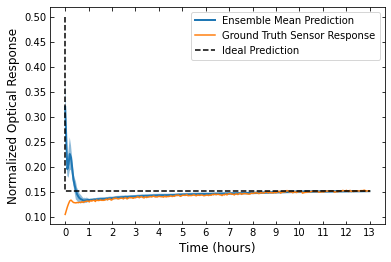

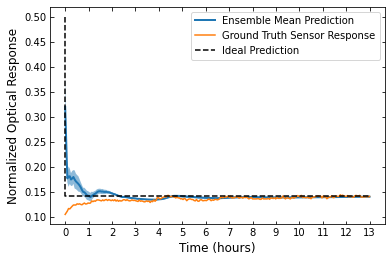

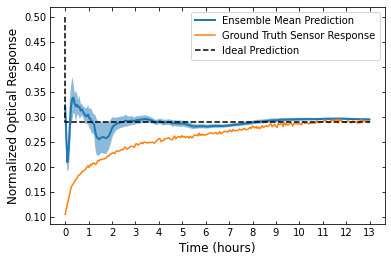

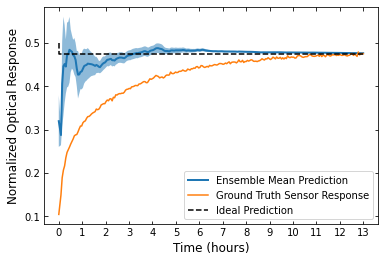

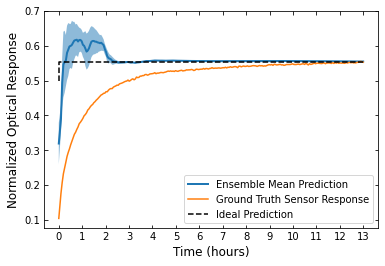

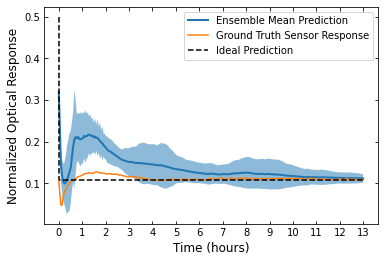

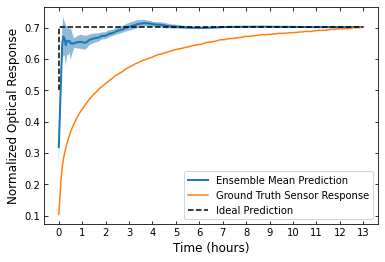

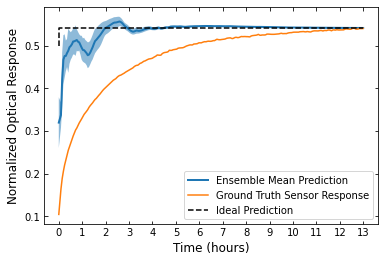

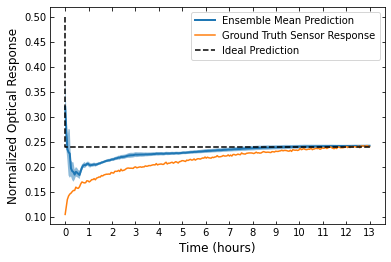

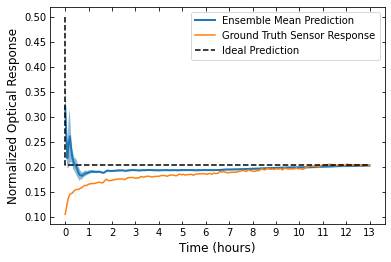

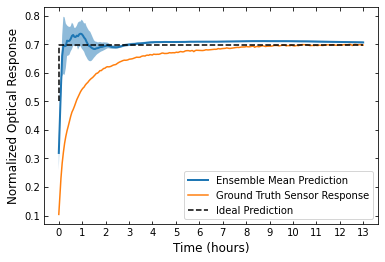

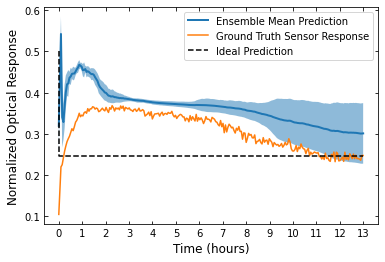

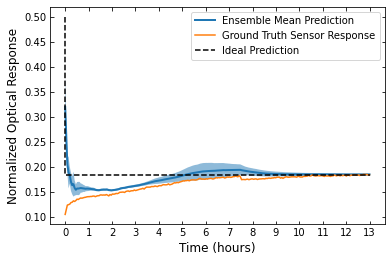

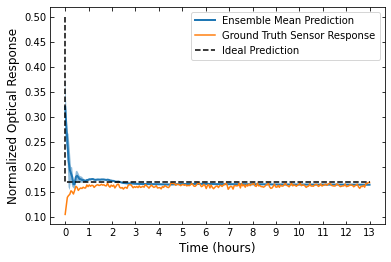

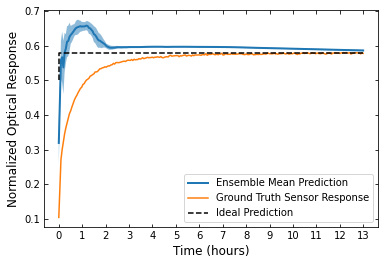

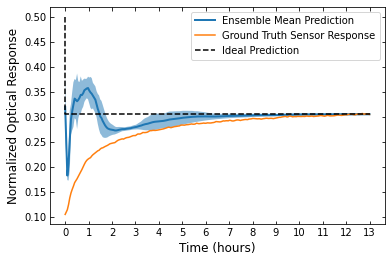

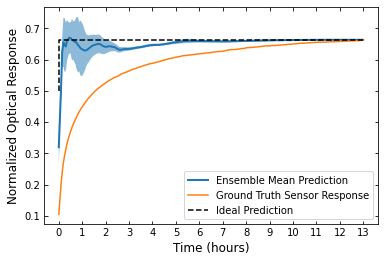

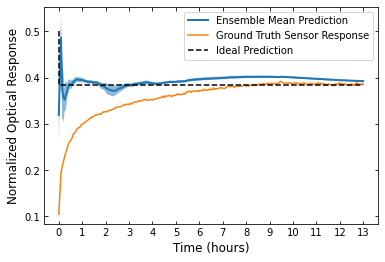

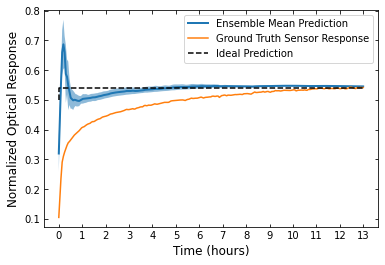

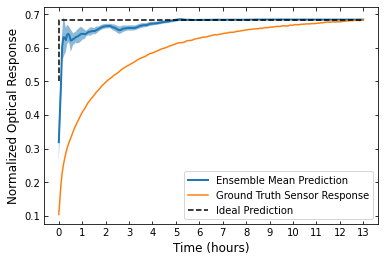

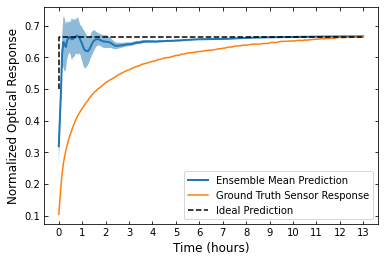

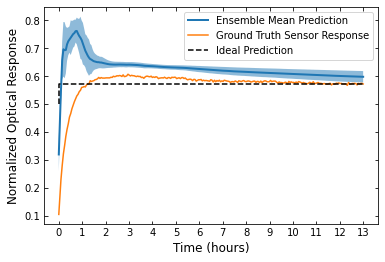

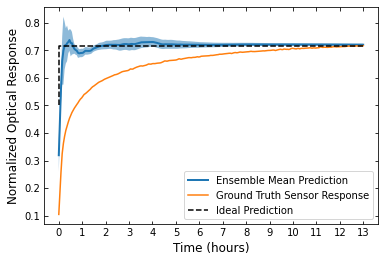

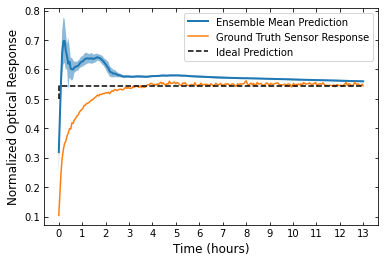

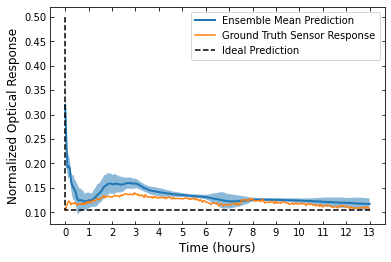

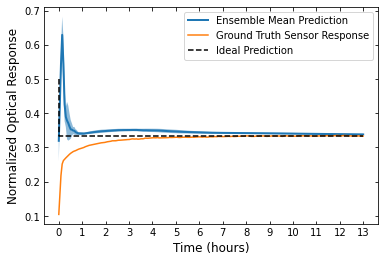

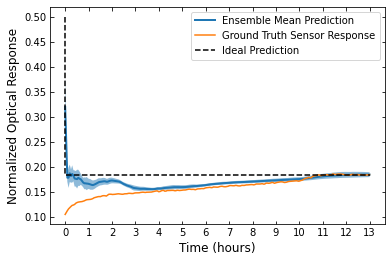

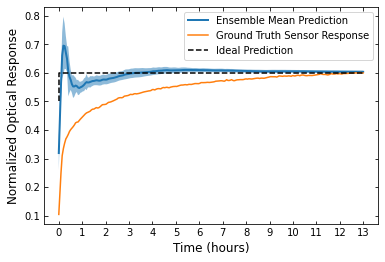

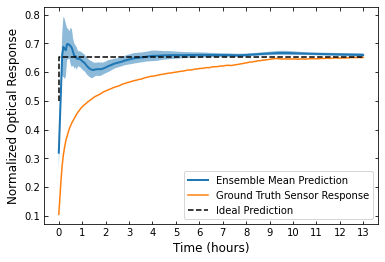

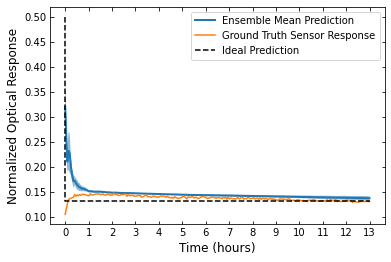

In [12]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split

## input parameters

# number of models in the ensemble
NumEnsemble = 10
# length of time series
SequenceLength = 250
StdevsFromMean = 2 #1, 2 and 3 standard deviations away from the mean encompasses 68%, 95% and 99.7% of the distribution, respectively 
TestOrTrainDataset = 'test' #'train' or 'test'
test_split = 0.2

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None)
time = df_full.iloc[0,1:]/3600
idealTime = np.append([0,0], time.iloc[2:,].values)
labels = df_full.iloc[1:,0]
df_data = df_full.iloc[1:,1:]

df = pd.read_csv(r"../TrainingData/SimulatedTrainingSet10000.csv",sep=',',header=0)
df_simulated = df.iloc[:,1:]

min_value, max_value = df_simulated.min().min(), df_simulated.max().max()

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str)

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
# min_value, max_value = df_train.min().min(), df_train.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)

if TestOrTrainDataset == 'train':
    X_train = df_norm_train.iloc[:,:SequenceLength].values
    y_train = df_norm_train.iloc[:,SequenceLength-1].values
    X_train = np.expand_dims(X_train, 2)
    y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
    y_train = np.expand_dims(y_train, 2)
    X = X_train
    y = y_train
elif TestOrTrainDataset == 'test':
    X_test = df_norm_test.iloc[:,:SequenceLength].values
    y_test = df_norm_test.iloc[:,SequenceLength-1].values
    X_test = np.expand_dims(X_test, 2)
    y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
    y_test = np.expand_dims(y_test, 2)
    X = X_test
    y = y_test
    
Mean = tf.zeros([len(X),SequenceLength])
Variance = tf.zeros([len(X),SequenceLength])

NumGoodModels = 0

for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    loss = bestModel.evaluate(X, y)
    if(loss<500):
        # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
        # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
        #for some reason predicting on X_train[0:6,::] for example does give identical results to predicting any one indivdually..
        prediction = bestModel.predict(X)
        
        Mean += prediction[:,:,0]
        Variance += (prediction[:,:,0])**2 + prediction[:,:,1]**2
        NumGoodModels += 1
        
Mean /= NumGoodModels
Variance /= NumGoodModels
Variance -= Mean**2

for mean,variance,x_train in zip(Mean,Variance,X):
    
    Stdev = np.squeeze(variance**0.5)
    
    time = np.array(time, dtype=float)
    idealPrediction = np.ones(len(idealTime))*x_train[-1]
    idealPrediction[0] = 0.5
    
    fig, ax = plt.subplots()

    ax.fill_between(time, (mean+Stdev*StdevsFromMean), (mean-Stdev*StdevsFromMean), alpha=.5, linewidth=0)
    ax.plot(time, mean, linewidth=2, label='Ensemble Mean Prediction')
    plt.plot(time,tf.squeeze(x_train), label="Ground Truth Sensor Response")
    plt.plot(idealTime,idealPrediction, label="Ideal Prediction",color='k',linestyle='--')

    ax.set_ylabel('Normalized Optical Response', fontsize = 12)
    ax.set_xlabel('Time (hours)', fontsize = 12)

    ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
    ax.tick_params(direction="in")
    ax.set_xticks(range(14))
    ax.legend()

    plt.show()

## Plot of experimental and individual pretrained model ensemble base learner predictions (including mean) and ideal responses

1/1 [==============================] - 1s 686ms/step
[0.60463524]
1/1 [==============================] - 1s 685ms/step
[0.60531425]
1/1 [==============================] - 1s 664ms/step
[0.60631025]
1/1 [==============================] - 1s 692ms/step
[0.60569525]
1/1 [==============================] - 1s 675ms/step
[0.604831]
1/1 [==============================] - 1s 692ms/step
[0.604479]
1/1 [==============================] - 1s 687ms/step
[0.60405993]
1/1 [==============================] - 1s 678ms/step
[0.60462505]
1/1 [==============================] - 1s 671ms/step
[0.6058584]
1/1 [==============================] - 1s 668ms/step
[0.6045657]


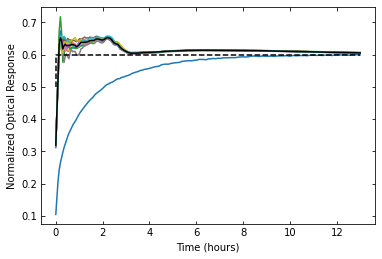

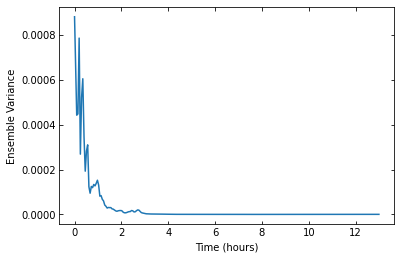

In [13]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split


NumEnsemble = 10
SequenceLength = 250
predict_num = 5
TestOrTrainDataset = 'test' #'train' or 'test'
test_split = 0.2

df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None)
time = df_full.iloc[0,1:]/3600
labels = df_full.iloc[1:,0]
df_train = df_full.iloc[1:,1:]

df = pd.read_csv(r"../TrainingData/SimulatedTrainingSet10000.csv",sep=',',header=0)
df_simulated = df.iloc[:,1:]

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str)

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_simulated.min().min(), df_simulated.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)

if TestOrTrainDataset == 'train':
    X_train = df_norm_train.iloc[:,:SequenceLength].values
    y_train = df_norm_train.iloc[:,SequenceLength-1].values
    X_train = np.expand_dims(X_train, 2)
    y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
    y_train = np.expand_dims(y_train, 2)
    X = X_train
    y = y_train
elif TestOrTrainDataset == 'test':
    X_test = df_norm_test.iloc[:,:SequenceLength].values
    y_test = df_norm_test.iloc[:,SequenceLength-1].values
    X_test = np.expand_dims(X_test, 2)
    y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
    y_test = np.expand_dims(y_test, 2)
    X = X_test
    y = y_test

Mean = tf.zeros([1,SequenceLength])
Variance = tf.zeros([1,SequenceLength])
X_predict = np.expand_dims(X[predict_num,::], 0)

idealTime = np.append([0,0], time.iloc[2:,].values)
idealPrediction = np.ones(len(idealTime))*X_predict[0,-1,0]
idealPrediction[0] = 0.5

fig, ax = plt.subplots()
NumGoodModels = 0
for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/SimulatedDataEnsembleModels/SimulatedDataEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    loss = bestModel.evaluate(X, y)
    if(loss<500):
        prediction = bestModel.predict(X_predict)
        plt.plot(time,tf.squeeze(prediction[:,:,0]),label=f"model {NumGoodModels} Prediction")
        print(prediction[:,-1,0])
        Mean += prediction[:,:,0]
        Variance += (prediction[:,:,0])**2 + prediction[:,:,1]**2
        NumGoodModels += 1
Mean /= NumGoodModels
Variance /= NumGoodModels
Variance -= Mean**2

plt.plot(time,tf.squeeze(Mean),label="Mean Prediction",color='k')
plt.plot(time,tf.squeeze(X_predict), label="Ground Truth Sensor Response")
plt.plot(idealTime,idealPrediction, label="Ideal Prediction",color='k',linestyle='--')
plt.xlabel("Time (hours)")
plt.ylabel("Normalized Optical Response")

ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
ax.tick_params(direction="in")
# plt.legend(loc='right')
plt.show()

fig, ax = plt.subplots()
plt.plot(time,tf.squeeze(Variance), label="Variance")
plt.xlabel("Time (hours)")
plt.ylabel("Ensemble Variance")
ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
ax.tick_params(direction="in")
plt.show()